<a href="https://colab.research.google.com/github/parthkohli92/Practice-Projects/blob/main/Timeseries_Forecasting_of_Covid_19_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Timeseries Forecasting of Covid-19 ARIMA

In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [3]:
train.sample(6)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
34608,34609,Gibraltar,United Kingdom,2020-05-09,146.0,0.0
9165,9166,Shanghai,China,2020-04-11,555.0,7.0
26778,26779,NaN,Timor-Leste,2020-04-29,24.0,0.0
6882,6883,Guangdong,China,2020-04-28,1588.0,8.0
4035,4036,NaN,Burundi,2020-02-01,0.0,0.0
29707,29708,Maryland,US,2020-02-28,0.0,0.0


In [4]:
test.sample(6)

,ForecastId,Province_State,Country_Region,Date
8190,8191,NaN,Nigeria,2020-04-22
814,815,NaN,Bahamas,2020-05-12
10685,10686,Guam,US,2020-04-23
8102,8103,NaN,Nicaragua,2020-04-20
1783,1784,Manitoba,Canada,2020-04-22
9079,9080,NaN,Saudi Arabia,2020-04-08


## EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35995 entries, 0 to 35994
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              35995 non-null  int64  
 1   Province_State  15295 non-null  object 
 2   Country_Region  35995 non-null  object 
 3   Date            35995 non-null  object 
 4   ConfirmedCases  35995 non-null  float64
 5   Fatalities      35995 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.6+ MB


In [8]:
train.isnull().sum()

Id                    0
Province_State    20700
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

In [9]:
15295-20700

-5405

In [10]:
train.describe()

,Id,ConfirmedCases,Fatalities
count,35995.000000,35995.000000,35995.000000
mean,17998.000000,3683.508737,243.560217
std,10391.005806,18986.978708,1832.966999
min,1.000000,0.000000,0.000000
25%,8999.500000,0.000000,0.000000
50%,17998.000000,19.000000,0.000000
75%,26996.500000,543.000000,7.000000
max,35995.000000,345813.000000,33998.000000


In [13]:
train['Province_State'].isna().sum()

20700

In [15]:
train['Province_State']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
35990    NaN
35991    NaN
35992    NaN
35993    NaN
35994    NaN
Name: Province_State, Length: 35995, dtype: object

In [16]:
df = train.fillna('NA').groupby(['Country_Region','Province_State','Date'])['ConfirmedCases'].sum() \
                          .groupby(['Country_Region','Province_State']).max().sort_values() \
                          .groupby(['Country_Region']).sum().sort_values(ascending = False)

top10 = pd.DataFrame(df).head(10)
top10

,ConfirmedCases
Country_Region,
US,1442653.0
Russia,262843.0
United Kingdom,238005.0
Spain,230183.0
Italy,223885.0
Brazil,220291.0
France,179630.0
Germany,175233.0
Turkey,146457.0


### Confirmed Cases Covid-19 by country

In [17]:
fig = px.bar(top10, x=top10.index, y='ConfirmedCases', labels={'x':'Country'},
             color="ConfirmedCases", color_continuous_scale=px.colors.sequential.Brwnyl)
fig.update_layout(title_text='Confirmed COVID-19 cases by country')
fig.show()

From the above graph, we can say that US has most Confirmed cases and followed by italy. The virus has began at China but virus is showing a greater impact on US and Italy than China

In [24]:
df_by_date = pd.DataFrame(train.fillna('NA').groupby(['Country_Region','Date'])['ConfirmedCases'].sum().sort_values().reset_index())

fig = px.bar(df_by_date.loc[(df_by_date['Country_Region'] == 'US') &(df_by_date.Date >= '2020-03-01')].sort_values('ConfirmedCases',ascending = False), 
             x='Date', y='ConfirmedCases', color="ConfirmedCases", color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Confirmed COVID-19 cases per day in US')
fig.show()

In [21]:
df_by_date = pd.DataFrame(train.fillna('NA').groupby(['Country_Region','Date'])['ConfirmedCases'].sum().sort_values().reset_index())

fig = px.bar(df_by_date.loc[(df_by_date['Country_Region'] == 'Italy') &(df_by_date.Date >= '2020-01-01')].sort_values('ConfirmedCases',ascending = False), 
             x='Date', y='ConfirmedCases', color="ConfirmedCases", color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Confirmed COVID-19 cases per day in Italy')
fig.show()

In [22]:
df_by_date = pd.DataFrame(train.fillna('NA').groupby(['Country_Region','Date'])['ConfirmedCases'].sum().sort_values().reset_index())

fig = px.bar(df_by_date.loc[(df_by_date['Country_Region'] == 'China') &(df_by_date.Date >= '2020-01-01')].sort_values('ConfirmedCases',ascending = False), 
             x='Date', y='ConfirmedCases', color="ConfirmedCases", color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Confirmed COVID-19 cases per day in China')
fig.show()

In [25]:
df_by_date = pd.DataFrame(train.fillna('NA').groupby(['Country_Region','Date'])['ConfirmedCases'].sum().sort_values().reset_index())

fig = px.bar(df_by_date.loc[(df_by_date['Country_Region'] == 'Spain') &(df_by_date.Date >= '2020-03-01')].sort_values('ConfirmedCases',ascending = False), 
             x='Date', y='ConfirmedCases', color="ConfirmedCases", color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Confirmed COVID-19 cases per day in Spain')
fig.show()

In [26]:
df_by_date = pd.DataFrame(train.fillna('NA').groupby(['Country_Region','Date'])['ConfirmedCases'].sum().sort_values().reset_index())

fig = px.bar(df_by_date.loc[(df_by_date['Country_Region'] == 'India') &(df_by_date.Date >= '2020-03-01')].sort_values('ConfirmedCases',ascending = False), 
             x='Date', y='ConfirmedCases', color="ConfirmedCases", color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Confirmed COVID-19 cases per day in India')
fig.show()

In [27]:
df_by_date = pd.DataFrame(train.fillna('NA').groupby(['Country_Region','Date'])['ConfirmedCases'].sum().sort_values().reset_index())

fig = px.bar(df_by_date.loc[(df_by_date['Country_Region'] == 'Germany') &(df_by_date.Date >= '2020-03-01')].sort_values('ConfirmedCases',ascending = False), 
             x='Date', y='ConfirmedCases', color="ConfirmedCases", color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Confirmed COVID-19 cases per day in Germany')
fig.show()

## Time Evaluation

In [28]:
df=train.groupby(['Date','Country_Region']).agg('sum').reset_index()
df.sample(5)

,Date,Country_Region,Id,ConfirmedCases,Fatalities
20125,2020-05-10,Guatemala,15175,1052.0,26.0
17661,2020-04-26,Western Sahara,35746,6.0,0.0
6417,2020-02-25,Switzerland,26140,1.0,0.0
10150,2020-03-17,Cambodia,4311,33.0,0.0
13265,2020-04-03,Belize,2833,4.0,0.0


In [33]:
def pltCountry_cases(ConfirmedCases,*argv):
    f, ax=plt.subplots(figsize=(15,7))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        plt.plot(country['Date'],country['ConfirmedCases'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of cases' )
  

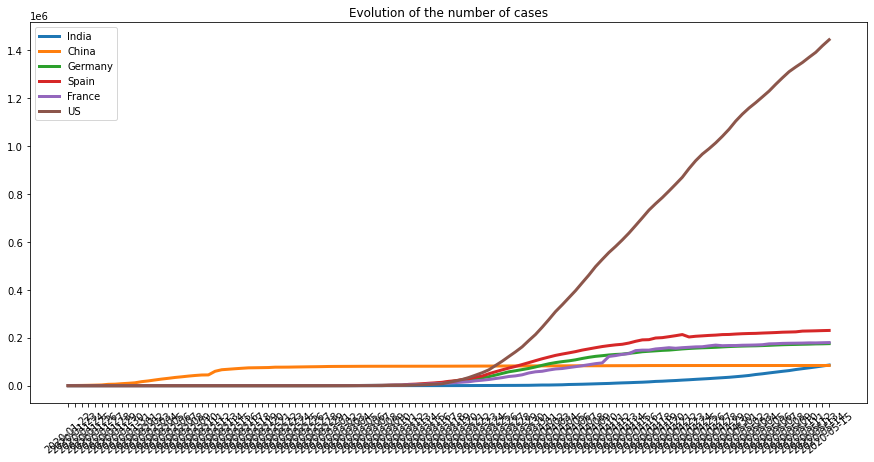

In [37]:
pltCountry_cases('ConfirmedCases','India','China', 'Germany','Spain','France','US' )

## ARIMA

In [38]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['ConfirmedCases']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['ConfirmedCases']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case])
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

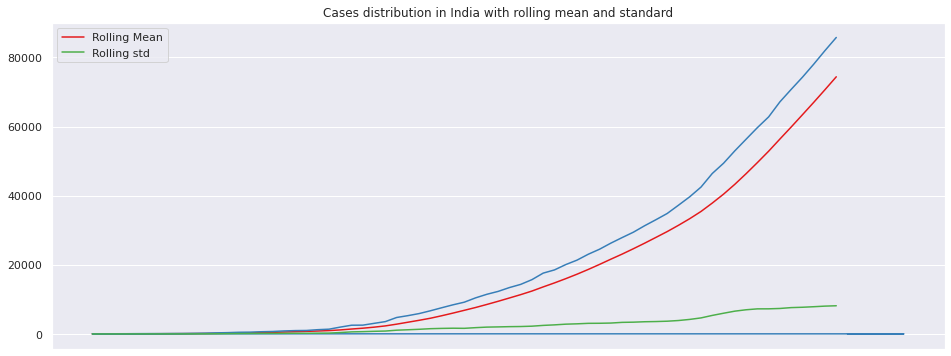

In [49]:
tsC1=roll('India')
rollPlot('India')

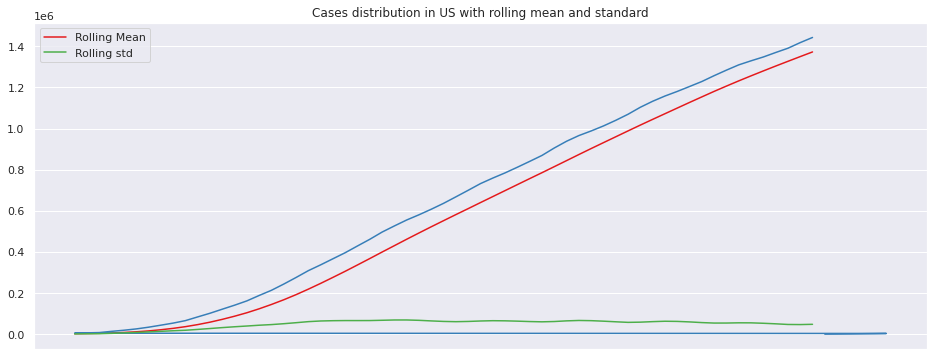

In [50]:
tsC2=roll('US')
rollPlot('US')

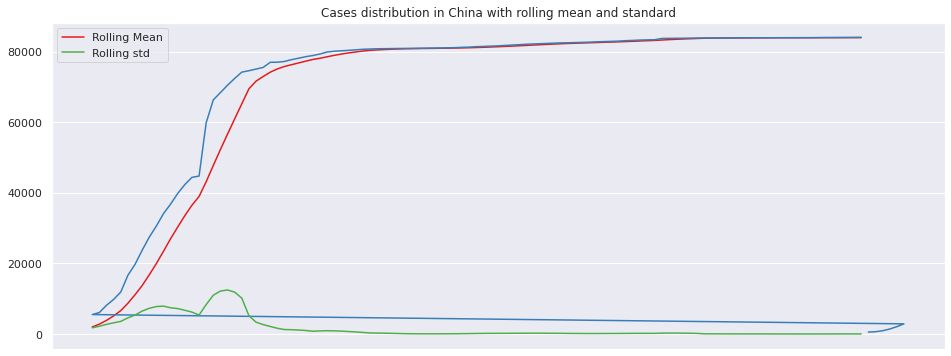

In [51]:
tsC3=roll('China')
rollPlot('China')

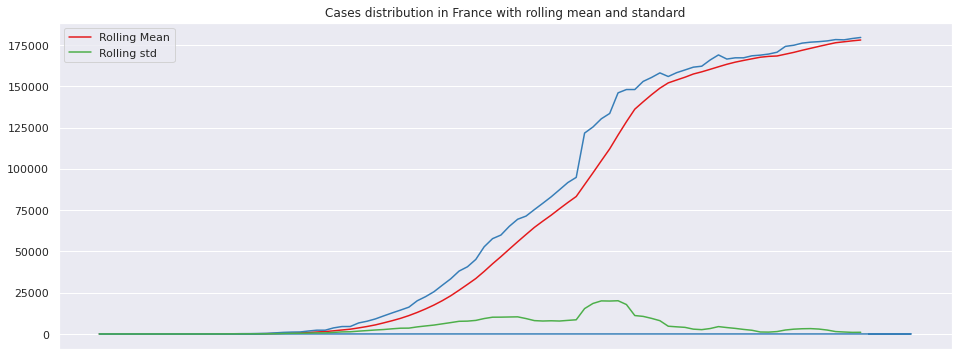

In [52]:
tsC4=roll('France')
rollPlot('France')

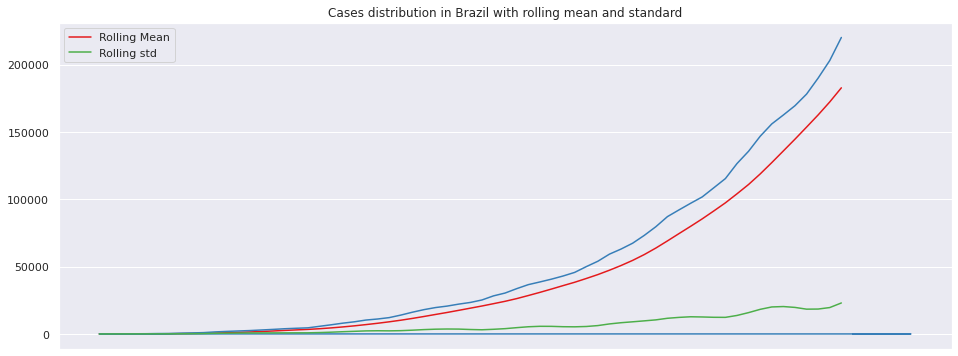

In [53]:
tsC5=roll('Brazil')
rollPlot('Brazil')

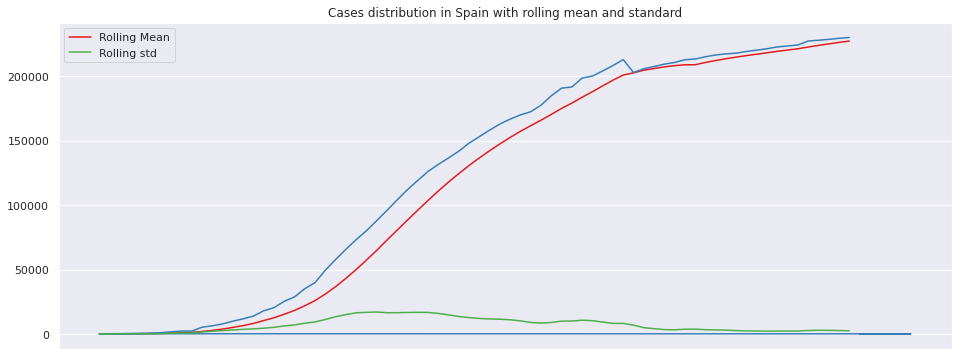

In [54]:
tsC6=roll('Spain')
rollPlot('Spain')